# CS 449 Final Project Update

Due: May 23, 2023 at 11:59pm

## 1. Names and Net IDs

Adam Holeman - agh4973

Jason Huang - jjh9397

Divy Kumar - dko6133

## 2. Abstract

*Write a new abstract that describes the motivation for your project and proposed methods. This should reflect any changes you've made, but you'll explain those changes later.*

> Our final project aims to generate images from a user-specified class in the CIFAR-10 dataset. We will compare a diffusion model with a DCGAN model using the FID metric for image quality, both unconditioned and with class-conditioning. Comparisons will include changes in diffusion architecture and hyperparameter experimentation. Time permitting, we will also train these models on different datasets with slightly larger resolution images.

## 3. Big Changes

*Describe any major changes that have taken your project in a new direction. What made you decide to make these changes? Were some things easier or harder than you expected?*

> None, we are still working on the same goals and feel like we are on track.

## 4a. Describe your dataset(s)

*This should be an updated version of your datasets section from your proposal. Write this section as if the reader hasn't read your original proposal. List the datasets you're using, where you found them, and what they contain. Be detailed! For each dataset, what does the data look like? What is the data representation? (e.g., what resolution of images? what length of sequences?) How is the data annotated or labeled? Include citations for the datasets. Include at least one citation of previous work that has used this data, or an explanation of why it hasn't been used before*

> The CIFAR-10 (Canadian Institute for Advanced Research) dataset consists of 60,000 images each of which is 32x32 pixels and is separated in to 10 classes. The data can be found at the following link: https://paperswithcode.com/dataset/cifar-10. The 10 labels are airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck. This dataset has been used as a benchmark in various imaging tasks, and in particular as an image generation benchmark. The following two papers use the CIFAR-10 dataset to train models related to the goals of our project:

> Wang, Zhendong, et al. ‘Diffusion-GAN: Training GANs with Diffusion’. ArXiv [Cs.LG], 2022, http://arxiv.org/abs/2206.02262. arXiv.

> Ho, Jonathan, et al. ‘Denoising Diffusion Probabilistic Models’. ArXiv [Cs.LG], 2020, http://arxiv.org/abs/2006.11239. arXiv.

> The citation for the dataset itself is included below.

> Krizhevsky, Alex. "Learning Multiple Layers of Features from Tiny Images." (2009)

## 4b. Load your dataset(s)

*Load at least a few examples and visualize them as best you can*

Files already downloaded and verified
Files already downloaded and verified


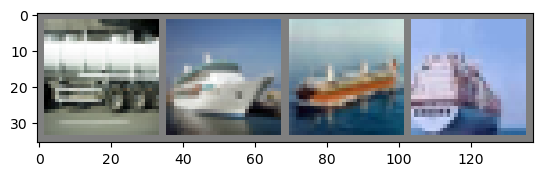

truck ship  ship  ship 


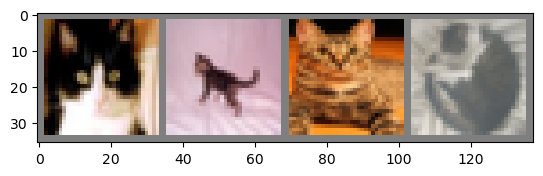

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
batch_size = 4
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

cat_idxs = np.where((np.array(trainset.targets) == 3))[0]
catset = torch.utils.data.Subset(trainset, cat_idxs)
catloader = torch.utils.data.DataLoader(catset, batch_size=batch_size, shuffle=True, num_workers=2)

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

images, _ = next(iter(catloader))
imshow(torchvision.utils.make_grid(images))

## 4c. Small dataset

*Describe the small dataset you constructed as requested in the project proposal. How many examples did you use? How large was the dataset in total?*

Since our images are already relatively small (32x32) for our purpose of generating images, we will limit the dataset to specific classes to create a small dataset and possibly the first 3000 examples if necessary to reduce size further. This makes sense for our purpose because generating images from a single class is still meaningful for our goals.

Our current overall dataset has 10 classes and 6000 examples per class for a total of approximately 160MB. Therefore, taking just a single class will approximately divide the size by 10, and taking the first 3000 examples of that class will approximately halve the size further to give a dataset that is less than 10MB in size. For our later goals to include class conditioning, we will start with 2 of the 10 classes to see if our class conditioning works. If the model takes too long to train, we may also keep the dataset size small with 3000 examples per class.

Currently, our small dataset is created by taking just the images with the cat label. This reduces the size of the dataset to 5000 images, which is approximately 12.5 MB. 

## 5. Updated Methods

*This should be an updated version of your methods section from your proposal. Write this section as if the reader hasn't read your original proposal. For example:*

Our primary goal is to implement a diffusion model and train it on the CIFAR-10 dataset. Here's a super brief summary of where these models come from.

<h1> <center> Basic Model Setup </center> </h1>

Diffusion models aim to approximate a probability distribution $p_{\theta}(x)$ over the input data $x$ by incorporating a set of latent variables (i.e. variable which are not observed in the data - meant to represent some 'features' of the data which the algorithm might observe), $z_{1},..., z_{t}$. By modeling a joint distribution $p_{\theta}(x, z_{1},..., z_{t})$, one reconstructs the distribution $p_{\theta}(x)$ by marginalizing with respect to the latent variables $z_{i}$. The joint distribution decomposes as a product of conditional distributions
\begin{align}
p_{\theta}(x, z_{i}) = p_{\theta}(x|z_{1}) \left(\prod_{i=1}^{t-1} p_{\theta}(z_{i} | z_{i+1}) \right) p_{\theta}(z_{t})
\end{align}
and each of these distributions is parameterized by a deep neural network. The posterior distribution $p_{\theta}(z_{1} | x)$ is typically intractable, so we introduce an auxiliary distribution $q_{\phi}(z_{1}|x)$ (as well as distributions $q_{\phi}(z_{i+1}| z_{i})$) which aims to approximate the posterior distribution, which we also parameterize by neural networks.



For more specific architectural details in the models (structure of the parameterizing neural networks, values of the many hyperparameters, etc...) we will adopt conventions from the literature, specifically citation 2, Ho et al.

<h1> <center> Training Method </center> </h1>

In the above context, there are two related objectives to optimize:
- Given some data $x$, we would like maximize the log-likelihood of the marginal distribution: $log(p_{\theta}(x))$. This improves the generative model.

- We would also like to ensure that our model $q_{\phi}(z_{1}|x)$ is a good approximation of the intractable posterior distribution $p_{\theta}(z_{1}|x)$, as for example measured by the Kullback-Leibler divergence: $D_{KL}(q_{\phi}(z_{1}|x)| p_{\theta}(z_{1}|x)$.

These two goals can be accomplished simultaneously by maximizing the 'evidence lower bound', abbreviated by ELBO. See citation 1 below.

In order to make optimization tractable, we will impose some hypotheses on these distributions - e.g. we'll start by taking the $q_{\phi}$ to be Gaussians
\begin{align}
q_{\phi}(z_{i}| z_{i-1}) = \mathcal{N}(z_{i} | \alpha_{t} z_{i-1}, \beta_{i} I)
\end{align}
for some hyperparameters $\alpha_{i}$ and $\beta_{i}$. Imposing a similar hypothesis on the prior distribution $p_{\theta}(z_{t})$ places us in a context where we can apply gradient based methods to optimize the ELBO using the reparameterization trick of Kingma and Welling (see Citation 1 below).

<h1> <center> Simplified Loss </center> </h1>

We will first be following the paper from Ho et al. in which a simpler loss function is derived from the above full ELBO formulation. In the simplified version, the loss is simply a mean squared error between the predicted noise and actual noise in the image. The overall idea is that if the model can correctly predict the amount of noise, it can then subtract the noise from a give image in order to denoise it.

**Citations**

1 - Kingma, Diederik P., and Max Welling. ‘Auto-Encoding Variational Bayes’. ArXiv [Stat.ML], 2022, http://arxiv.org/abs/1312.6114. arXiv.

2 - Ho, Jonathan, et al. ‘Denoising Diffusion Probabilistic Models’. ArXiv [Cs.LG], 2020, http://arxiv.org/abs/2006.11239. arXiv.

3 - Kingma, Diederik P., et al. ‘Variational Diffusion Models’. ArXiv [Cs.LG], 2023, http://arxiv.org/abs/2107.00630. arXiv.

## 6. Proposed Deliverables

*Copy the deliverables from your proposal and write a sentence saying whether you completed this goal, made progress on this goal, or abandoned this goal. Unless you completed the goal, give an explanation of how it went.*

### 6.1 Previous Essential Goals
- Our plan is to create the model from scratch following the implementation from Ho et al. We will be using the implementation from https://www.youtube.com/watch?v=a4Yfz2FxXiY as reference if we get stuck. One change we may make right away is to use a simpler architecture for the neural network, since U-Nets are expensive to train. **COMPLETED: we have modified the reference code to work with our image size, and are currently debugging our own version; both use U-Nets**
- We will evaluate the performance of the model using this FID implementation: https://pytorch.org/ignite/generated/ignite.metrics.FID.html. **INCOMPLETE, but we now have image samples from both models to use for the comparison**
- We are revising this goal to be the training of a DCGAN model on CIFAR-10 following https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html. We will keep both this and the diffusion model unconditional at first. **COMPLETED: we have a working DCGAN that is trained on our mini cat dataset**

### 6.2 Previous Desired Goals
- We will compare different neural network architectures such as U-Net and simpler architectures (e.g. a CNN). **IN PROGRESS: we have experimented with different size U-Nets with the diffusion model**
- We will experiment with hyperparameters such as noise schedule, number of timesteps, and width/size of NN layers to improve performance. **IN PROGRESS: we are still training both types of models with different hyperparameters**
- Our diffusion model will do conditional generation, following the paper example and reference implementation. **INCOMPLETE: we do not have conditional models yet for either GANs or Diffusion models**
- We will compare our GAN against our diffusion model using FID score. The architecture of the GAN will follow the above pytorch tutorial, but we will add in class conditioning. **INCOMPLETE: we do not have conditional models to compare**

### 6.3 Previous Stretch Goals
- We would like to explore ways of interpreting and visualizing the model. **NOT STARTED**
  - For example, since we plan to create a conditional model, we could identify which parts of the network are activated by different labels.
  - Once having identified neurons or layers which exhibit high activation for certain labels, we could try to synthesize input which selectively activates   these neurons or layers. Feeding this input into the denoising net, what does our model generate? Does the output exhibit features of the original class? How does this change as we explore different parts of the denoising network? 
- We would like to explore the use of Low Rank Adaptation to be able to fine tune the model with small amounts of data. **NOT STARTED**
  - Following the paper, the idea would be to first train the model and then freeze the weights. The model can then be fine tuned with much fewer examples and parameters trained by replacing the gradient update with a low rank decomposition BA. B and A are low rank matrices and contain the parameters that are trained, while the pretrained weights of the model are frozen. The paper and implementations typically apply these to specific layers such as Attention layers, but in theory it should work with any of the weight matrices in a neural network so we believe as a stretch goal it could be added to give a new way to fine tune the model.

## 7. Results So Far

*Show the results of your methods trained on your data. You should at least have empirical results for the small dataset described in 4c. Unless you are doing generation or another task where simple models (e.g., linear regression or logistic regression) aren't applicable, we strongly encourage you to compare your initial results against a simple baseline. If you have additional results, you're welcome to include those as well.*

> DCGAN - 1024 epochs, using label smoothing and adding noise to discriminator inputs
> 
> ![](models/CatGAN/1024ep_64nf_128nz_smoothed_noised_default-D_block2outngfx4-G.pt-image.png)

> Diffusion - 1024 epochs, original U-Net structure modified to work with 32x32 images
>
> ![](output/1024ep-3e4lr-3xblocks/output.png)

## 8. New Deliverables

*For any proposed deliverables that you did NOT complete or abandon, copy them into these lists below. Then, if you have abandoned or completed your Desired or Stretch goals, add new goals until you have at least two goals per category.*

8.1 New Essential Goals

- We will evaluate the performance of the model using this FID implementation: https://pytorch.org/ignite/generated/ignite.metrics.FID.html.

8.2 New Desired Goals

- We will compare different neural network architectures such as U-Net and simpler architectures (e.g. a CNN). **IN PROGRESS: we have experimented with different size U-Nets with the diffusion model**
- We will experiment with hyperparameters such as noise schedule, number of timesteps, and width/size of NN layers to improve performance. **IN PROGRESS: we are still training both types of models with different hyperparameters**
- Our diffusion model will do conditional generation, following the paper example and reference implementation. **INCOMPLETE: we do not have conditional models yet for either GANs or Diffusion models**
- We will compare our GAN against our diffusion model using FID score. The architecture of the GAN will follow the above pytorch tutorial, but we will add in class conditioning. **INCOMPLETE: we do not have conditional models to compare**

8.3 New Stretch Goals

- We would like to explore ways of interpreting and visualizing the model. **NOT STARTED**
  - For example, since we plan to create a conditional model, we could identify which parts of the network are activated by different labels.
  - Once having identified neurons or layers which exhibit high activation for certain labels, we could try to synthesize input which selectively activates   these neurons or layers. Feeding this input into the denoising net, what does our model generate? Does the output exhibit features of the original class? How does this change as we explore different parts of the denoising network? 
- We would like to explore the use of Low Rank Adaptation to be able to fine tune the model with small amounts of data. **NOT STARTED**
  - Following the paper, the idea would be to first train the model and then freeze the weights. The model can then be fine tuned with much fewer examples and parameters trained by replacing the gradient update with a low rank decomposition BA. B and A are low rank matrices and contain the parameters that are trained, while the pretrained weights of the model are frozen. The paper and implementations typically apply these to specific layers such as Attention layers, but in theory it should work with any of the weight matrices in a neural network so we believe as a stretch goal it could be added to give a new way to fine tune the model.

## 9. Hopes and Concerns

*What's gone well so far? What's been the hardest thing?*

> The U-Net takes a long time to train so Colab kicks us off sometimes.

## 10. References

*Cite the papers or sources that you used to discover your datasets and/or models, if you didn't include the citation above. For example:*

LeCun, Yann, et al. "Gradient-based learning applied to document recognition." Proceedings of the IEEE 86.11 (1998): 2278-2324.